In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
from dataclasses import dataclass
import torch.nn as nn
from scipy.special import hermite,factorial
from numpy.polynomial import Chebyshev

import matplotlib.pyplot as plt

from tqdm import tqdm

## Data

In [15]:
@dataclass
class ProcessConfig:
    """configure the data generating process"""
    seq_len: int = 2000
    num_seeds: int = 3 
    num_samples_per_task: int = 100

class DataGeneratingProcess:
    """data generating process"""
    def __init__(self, cfg):
        self.seq_len = cfg.seq_len
        self.num_seeds = cfg.num_seeds
        self.n = cfg.num_samples_per_task
        
    def generate_data(self):
        """generate data sequences over the specified number of seeds"""
        xseq, yseq, taskseq = [], [], []
        tseq = []
        for _ in range(self.num_seeds):
            dat = self.generate_sequence(np.random.randint(0, 1000))
            xseq.append(dat[0])
            yseq.append(dat[1])
            taskseq.append(dat[2])
            tseq.append(dat[2])
            
        xseq = np.array(xseq)
        yseq = np.array(yseq)
        tseq = np.array(tseq)
        taskseq = np.array(taskseq)

        self.data = {'x': xseq,
                     'y': yseq,
                     't': tseq,
                     'task': taskseq}

    def generate_sequence(self, seed):
        """generate a sequence of data"""
        np.random.seed(seed)
        
        m = 0.5
        data = []
        for t in range(self.seq_len):
            # generate samples from U[t-2, t-1] & U[t+1, t+2]
            x1 = np.random.uniform(m*t-2, m*t-1, self.n // 2)
            x2 = np.random.uniform(m*t+1, m*t+2, self.n // 2)

            x = np.concatenate((x1, x2))
            y = np.concatenate((np.ones(self.n // 2), np.zeros(self.n // 2)))

            data.append([x, y, t * np.ones(self.n)])

        data = np.concatenate(data, axis=-1)
        Xdat = data[0, :].reshape(-1, 1)
        Ydat = data[1, :].astype(int)
        tind = data[2, :]
        return Xdat, Ydat, tind
    
    def generate_at_time(self, t, num_samples):
        """generate a test sample of data (x, y) ~ p_t from the marginal 
        of the process at time t. This is used to evaluate the instantaneous
        loss of the predictor
        """
        # generate samples from U[t-2, t-1] & U[t+1, t+2]
        m = 1
        x1 = np.random.uniform(m*t-2, m*t-1, num_samples // 2)
        x2 = np.random.uniform(m*t+1, m*t+2, num_samples // 2)
        
        Xdat = np.array([x1, x2]).reshape(-1, 1)
        Ydat = np.array([np.ones(num_samples//2), np.zeros(num_samples//2)]).reshape(-1)
        tdat = t * np.ones(num_samples).reshape(-1)
        
        x = torch.from_numpy(Xdat).float()
        y = torch.from_numpy(Ydat).long()
        t = torch.from_numpy(tdat).float()
        
        return x, y, t
    
class SyntheticDataset(Dataset):
    """Form the torch dataset"""
    def __init__(self, data, present, run_id, test):
        self.x = torch.from_numpy(data['x'][run_id]).float()
        self.y = torch.from_numpy(data['y'][run_id]).long()
        self.t = torch.from_numpy(data['t'][run_id]).float()

        self.train_idx = torch.where(self.t < present)
        
        if test:
            # Use data from time 'idx' onwards for testing
            test_idx = torch.where(self.t >= present)
            self.x = self.x[test_idx]
            self.y = self.y[test_idx]
            self.t = self.t[test_idx]
        else:
            # Use data up to time 'idx' onwards for training
            train_idx = torch.where(self.t < present)
            self.x = self.x[train_idx]
            self.y = self.y[train_idx]
            self.t = self.t[train_idx]
        
        self.x = self.minimax_normalize(self.x)
        self.t = self.minimax_normalize(self.t)

    def minimax_normalize(self, a):
        tr_min, tr_max = a[self.train_idx].min(), a[self.train_idx].max()
        return (a - tr_min)/(tr_max - tr_min)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        t = self.t[idx]
        return x, y, t

In [16]:
class MLP(nn.Module):
    """a simple MLP architecture for implementing both vanilla-MLP and
    prospective-MLP
    """
    def __init__(self, in_dim=1, out_dim=2, hidden_dim=8, tdim=1, prospective=False):
        super(MLP, self).__init__()
        self.prospective = prospective
        if prospective:
            self.fc1 = nn.Linear(in_dim + tdim, hidden_dim)
        else:
            self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, out_dim)

    def forward(self, x, t):
        if self.prospective:
            x = torch.cat([x, t.unsqueeze(-1)], dim=-1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [17]:
import random

def set_seed(acorn):
    """set random seed"""
    random.seed(acorn)
    np.random.seed(acorn)
    torch.manual_seed(acorn)
    torch.cuda.manual_seed(acorn)
    torch.cuda.manual_seed_all(acorn)

def get_dataloaders(dp, t, seed):
    """obtain the dataloaders"""
    train_dataset = SyntheticDataset(dp.data, t, seed, test=False)
    test_dataset = SyntheticDataset(dp.data, t, seed, test=True)
    ttest_dataset = TensorDataset(*dp.generate_at_time(t, 500))

    if len(train_dataset) > 32:
        bs = 32
    else:
        bs = 2

    trainloader = DataLoader(
        train_dataset,
        batch_size=bs,
        shuffle=True,
        drop_last=True
    )
    testloader = DataLoader(
        test_dataset, 
        batch_size=100,
        shuffle=False
    )
    ttestloader = DataLoader(
        ttest_dataset, 
        batch_size=100,
        shuffle=False
    )
    return trainloader, testloader, ttestloader

class Trainer:
    """trainer class for the models"""
    def __init__(self, model, train_loader, test_loader, ttest_loader, criterion, optimizer, device, verbose=False):
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.ttest_loader = ttest_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.verbose = verbose

    def train_one_epoch(self):
        self.model.train()
        total_loss = 0.0
        
        for batch in self.train_loader:
            batch = [b.to(self.device) for b in batch]
            x, y, t = batch
            outputs = self.model(x, t)

            loss = self.criterion(outputs.squeeze(), y)

            self.optimizer.zero_grad()  
            loss.backward()            
            self.optimizer.step() 

            total_loss += loss.clone().detach().item()

        return total_loss / len(self.train_loader)

    def evaluate(self, test_loader, ttest_loader=None):
        self.model.eval()
        perrs = []
        with torch.no_grad():
            for batch in test_loader:
                batch = [b.to(self.device) for b in batch]
                x, y, t = batch
                logits = self.model(x, t)
                probs = torch.softmax(logits, dim=1)
                err = (probs.argmax(dim=1) != y).float()
                perrs.append(err.cpu().numpy())
        perrs = np.concatenate(perrs)
        times = self.test_loader.dataset.t
        ploss = np.nanmean([np.mean(perrs[times == i]) for i in torch.unique(times)])

        if ttest_loader:
            errs = []
            with torch.no_grad():
                for batch in ttest_loader:
                    batch = [b.to(self.device) for b in batch]
                    x, y, t = batch
                    logits = self.model(x, t)
                    probs = torch.softmax(logits, dim=1)
                    err = (probs.argmax(dim=1) != y).float()
                    errs.append(err.cpu().numpy())
            iloss = np.concatenate(errs).mean()
            return ploss, iloss
        else:
            return ploss

    def train(self, num_epochs):
        progress_bar = tqdm(range(num_epochs), desc="Training", unit="epoch")

        for epoch in progress_bar:
            train_loss = self.train_one_epoch()
            if self.verbose:
                progress_bar.set_description(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {train_loss:.4f}")

In [18]:
# configure and obtain the data generating process
cfg = ProcessConfig(
    seq_len=2000,
    num_seeds=1,
    num_samples_per_task=20
)
dp = DataGeneratingProcess(cfg)
dp.generate_data()

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# methods being considered
methods = ["Prospective"]

tind = 500

# run experiment
seed = 0
acorn = seed * 1000 + 1998
set_seed(acorn)
        
trainloader, testloader, ttestloader = get_dataloaders(dp, tind, seed)
        
model = MLP(prospective=True)
model.to(device)

optimizer = torch.optim.SGD(
    model.parameters(), 
    lr=0.01,
    # momentum=0.9, 
    # nesterov=True,
    weight_decay=0.001
)
criterion = nn.CrossEntropyLoss()

trainer = Trainer(model, trainloader, testloader, ttestloader, criterion, optimizer, device, verbose=True)
trainer.train(num_epochs=200)

Epoch [200/200] - Loss: 0.6890: 100%|██████████| 200/200 [00:23<00:00,  8.64epoch/s]


In [19]:
print(f"Prospective Loss at t = {tind}: {trainer.evaluate(testloader):.3f}")

Prospective Loss at t = 500: 0.420


In [20]:
xx, tt = torch.meshgrid(torch.linspace(0, 10, 100), torch.linspace(0, 10, 100))
model.eval()
scores = []
for x, t in zip(xx.ravel(), tt.ravel()):
    logits = model(x.unsqueeze(0), t)
    score = torch.nn.functional.softmax(logits, dim=-1).detach()[0]
    scores.append(score)
scores = np.array(scores)

In [21]:
train_dataset = SyntheticDataset(dp.data, tind, seed, test=False)
x_train = train_dataset.x.numpy()
y_train = train_dataset.y.numpy()
t_train = train_dataset.t.numpy()

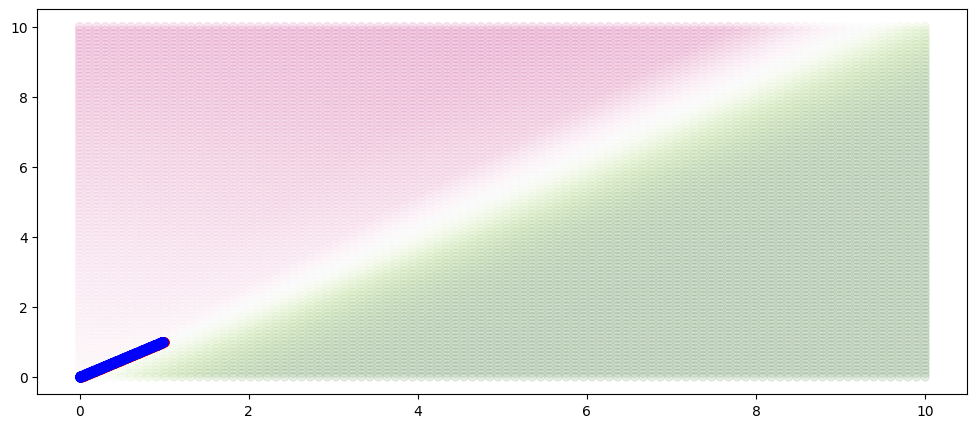

In [22]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.scatter(xx.ravel().numpy(), tt.ravel(), c=scores, cmap='PiYG', vmin=0, vmax=1, alpha=0.1)
ax.scatter(x_train[y_train == 0], t_train[y_train == 0], c='red')
ax.scatter(x_train[y_train == 1], t_train[y_train == 1], c='blue')
plt.show()

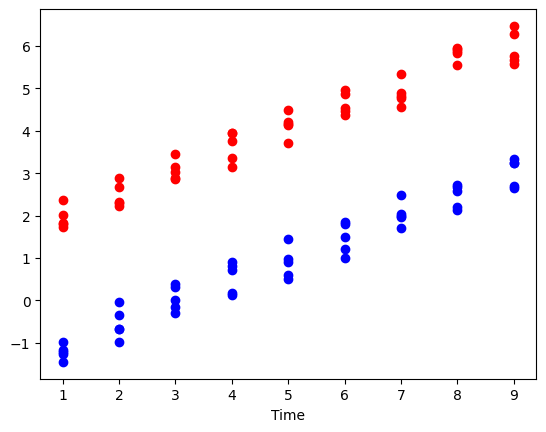

In [23]:
cfg = ProcessConfig(
    seq_len=500,
    num_seeds=1,
    num_samples_per_task = 10
)

dp = DataGeneratingProcess(cfg)
dp.generate_data()

x = dp.data['x'][0]
y = dp.data['y'][0]
t = dp.data['t'][0]

for i in range(1, 10):
    indices = (t == i)
    xi = x[indices]
    ti = t[indices]
    yi = y[indices]
    plt.scatter(ti[yi == 0], xi[yi == 0], color='red')
    plt.scatter(ti[yi == 1], xi[yi == 1], color='blue')
plt.xlabel("Time")
plt.show()